# Stablecoin Simulation

---

This notebook is part of a stablecoin project.

---

# Table of Contents

1. [System Requirements](#1.-System-Requirements)
  * [Requirements Analysis](#Requirements-Analysis)
  * [Visual System Mappings](#Visual-System-Mappings)
  * [Mathematical Specification](#Mathematical-Specification)


2. [System Design](#2.-System-Design)
  * [Differential Specification](#Differential-Specification)
  * [Modelling](#Modelling)
  * [Simulation](#Simulation)


---

# 1. System Requirements

## Requirements Analysis

**Goal:** Simulate a simple collateral-backed stablecoin and examine the effects of external price shocks

**Scope:** Showcasing how simulations can offer insights into specific dynamics

**Question:** How do price shocks affect vault liquidations?

**Assumptions:**
- The price of the underlying collateral asset follows a simple stochastic process
- The _Vault Owners_ maintain their vault positions following a certain strategy
- Liquidations are triggered immediately and the collateral flows into the so called _Residual Ecosystem_

## Visual System Mappings

#### Entity Relationship Diagram

TODO

#### Stock & Flow Diagram

TODO

## Mathematical Specification

TODO

---

# 2. System Design

## Differential Specification

TODO

## Modelling

In [18]:
##############
# 0. IMPORTS #
##############

# Standard libraries
import numpy as np
import copy

# model
from model.state_variables import set_initial_state

# Analysis and plotting modules
import pandas as pd
import plotly.express as px

# radCAD modules
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend


In [19]:
################
# 0 PARAMETERS #
################

INITIAL_COLL_PRICE = 3000
NUM_OWNERS = 100
MIN_COLL_RATIO = 1.5
LIQUIDATION_RATIO = 1/MIN_COLL_RATIO

# RISKY, RISK-AVERSE, PASSIVE, IRRATIONAL
STRATEGY_DISTRIBUTION = [0.5, 0.1, 0.35, 0.05]


In [20]:
######################
# 1. STATE VARIABLES #
######################

initial_state = set_initial_state(INITIAL_COLL_PRICE, NUM_OWNERS, LIQUIDATION_RATIO, STRATEGY_DISTRIBUTION)
initial_state

########################
# 2. SYSTEM PARAMETERS #
########################

system_params = {
    "initial_coll_price": [INITIAL_COLL_PRICE],
    "num_owners": [NUM_OWNERS],
    "liquidation_ratio": [LIQUIDATION_RATIO],
    "stability_fee": [0.05],
    
    # Price simulation parameters, values are defined per year
    "coll_price_drift": [0.2],
    "coll_price_vol": [0.3],
    "jump_rate": [0.25],
    "jump_param_a": [0.1],
    "jump_param_b": [0.2],
}

<>:37: SyntaxWarning:

invalid escape sequence '\m'

<>:37: SyntaxWarning:

invalid escape sequence '\m'

/var/folders/1l/jpvj4xhs17x5ylkrxzvqgxpm0000gn/T/ipykernel_11993/2657722909.py:37: SyntaxWarning:

invalid escape sequence '\m'



<Figure size 1500x1000 with 0 Axes>

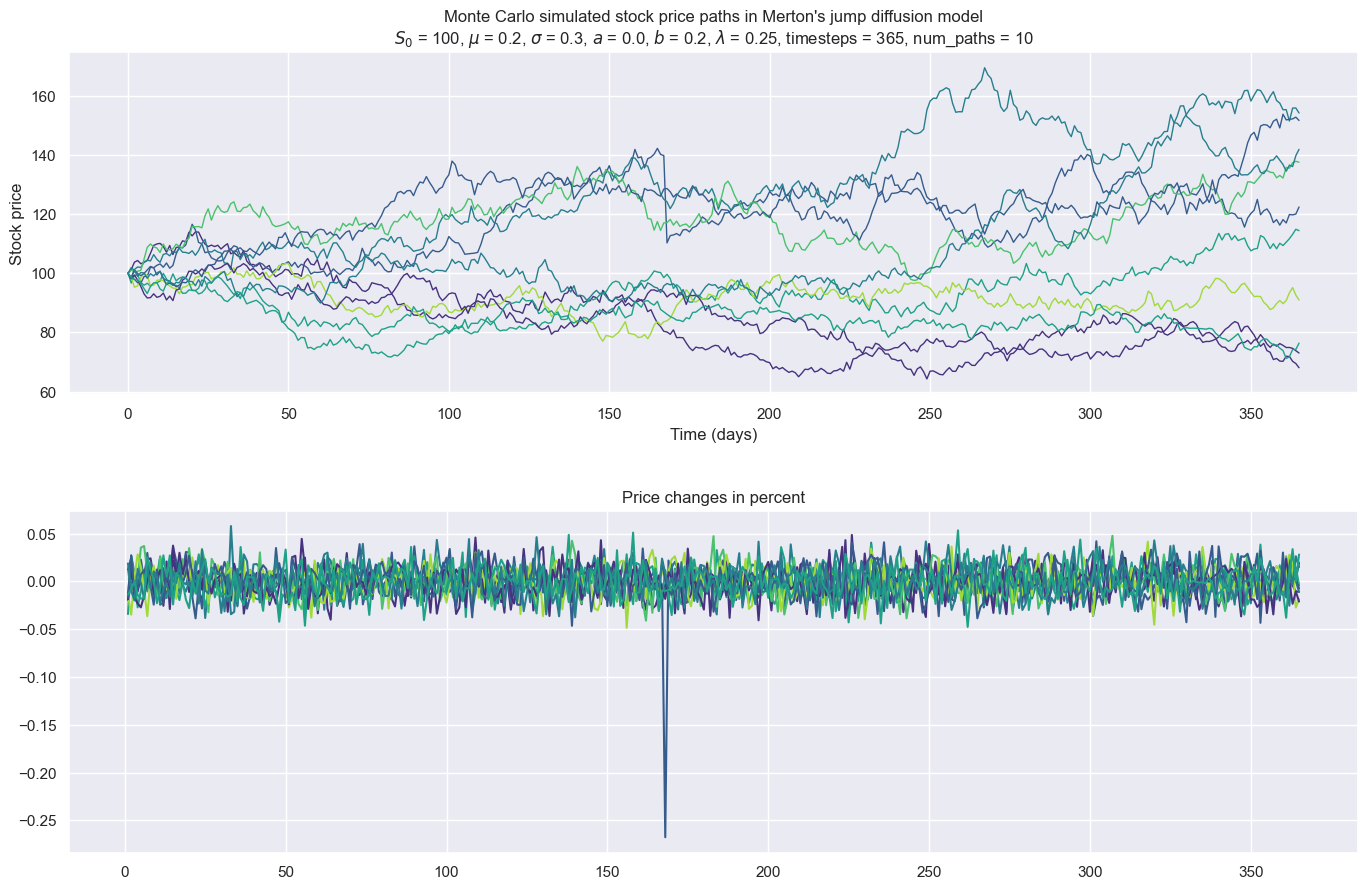

In [21]:
# This section is just to examine the jump diffusion price process

from utils.price_simulation import jump_diffusion
import matplotlib.pyplot as plt
import seaborn as sns

num_paths = 10
timesteps = 365
price_params = {
    "coll_price_drift": 0.2,
    "coll_price_vol": 0.3,
    "jump_rate": 0.25,
    "jump_param_a": 0.0,
    "jump_param_b": 0.2,
}
simulated_price_paths = jump_diffusion(100, price_params, num_paths=num_paths, timesteps=timesteps)
simulated_price_changes = np.diff(simulated_price_paths) / simulated_price_paths[:, 1:]

# Choose palette, figure size, and define figure axes
sns.set_theme(palette='viridis')
plt.figure()
width = 15
height = 10
plt.rcParams['figure.figsize'] = [width, height]
fig, ax = plt.subplots(2,1)
fig.tight_layout(pad=5.0)

t = np.linspace(0, timesteps, timesteps+1)

price_path = ax[0].plot(t, simulated_price_paths.transpose());
price_changes = ax[1].plot(t[1:], simulated_price_changes.transpose());

# Make drawn paths thinner by decreasing line width
plt.setp(price_path, linewidth=1);

# Set title (LaTeX notation) and x- and y- labels
ax[0].set(title="Monte Carlo simulated stock price paths in Merton's jump diffusion model\n$S_0$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, $b$ = {}, $\lambda$ = {}, timesteps = {}, num_paths = {}".format(100, price_params["coll_price_drift"], price_params["coll_price_vol"], price_params["jump_param_a"], price_params["jump_param_b"], price_params["jump_rate"], timesteps, num_paths), xlabel='Time (days)', ylabel='Stock price')
ax[1].set(title="Price changes in percent")

plt.show()

In [22]:

##################################
# 5. PARTIAL STATE UPDATE BLOCKS #
##################################

from model.policy_functions import p_coll_price, p_liquidation, p_vault_management
from model.state_update_functions import s_collateral, s_owners, s_stability_pool


state_update_blocks = [
    {
        'policies': {
            'coll_price': p_coll_price
        },
        'variables': {
            'collateral': s_collateral,
        }
    },
    {
        'policies': {'liquidation': p_liquidation},
        'variables': {
            'stability_pool': s_stability_pool,
            'owners': s_owners
        }
    },
        {
        'policies': {'vault_management': p_vault_management},
        'variables': {
            'stability_pool': s_stability_pool,
            'owners': s_owners
        }
    }
]

## Simulation

In [23]:
####################
# 6. CONFIGURATION #
####################

model = Model(
    initial_state=initial_state,
    state_update_blocks=state_update_blocks,
    params=system_params
)

simulation = Simulation(
    model=model,
    timesteps=1000,  # Number of timesteps
    runs=10  # Number of Monte Carlo Runs
)

experiment = Experiment([simulation])
# Select the Pathos backend to avoid issues with multiprocessing and Jupyter Notebooks
experiment.engine = Engine(backend=Backend.PATHOS, drop_substeps=True)


################
# 7. EXECUTION #
################

raw_result = experiment.run()


In [24]:
####################################
# 8. SIMULATION OUTPUT PREPARATION #
####################################

from utils.metrics import  debt_collateral_ratio, num_liquidations



simulation_result = pd.DataFrame(raw_result)

owner_number = 0
owner_strategy = simulation_result["owners"][0][owner_number].strategy.name

simulation_result['coll_price'] = [t.price for t in simulation_result['collateral']]
simulation_result['coll_price_change'] = simulation_result['coll_price'].pct_change()
simulation_result['stability_pool_balance'] = [t.stable_coin_balance for t in simulation_result['stability_pool']]
simulation_result['num_liquidations'] = [num_liquidations(t) for t in simulation_result['owners']] 
simulation_result['debt_collateral_ratio'] = [debt_collateral_ratio(owners=t, coll_price=coll_price) for (t, coll_price) in zip(simulation_result['owners'], simulation_result["coll_price"])] 
simulation_result['vault_collateral'] = [t[owner_number].vault.collateral_balance * coll_price for (t, coll_price) in zip(simulation_result['owners'], simulation_result["coll_price"])] 
simulation_result['vault_debt'] = [t[owner_number].vault.debt_balance for t in simulation_result['owners']]
simulation_result['liquidation_buffer'] = [t[owner_number].vault.collateral_balance * coll_price * LIQUIDATION_RATIO - t[owner_number].vault.debt_balance for (t, coll_price) in zip(simulation_result['owners'], simulation_result["coll_price"])] 
simulation_result['excess_collateral'] = [t[owner_number].vault.collateral_balance * coll_price * (1 - LIQUIDATION_RATIO) for (t, coll_price) in zip(simulation_result['owners'], simulation_result["coll_price"])] 
simulation_result['wallet_collateral'] = [t[owner_number].wallet.collateral_balance * coll_price for (t, coll_price) in zip(simulation_result['owners'], simulation_result["coll_price"])] 
simulation_result['wallet_stable_coin'] = [t[owner_number].wallet.stable_coin_balance for t in simulation_result['owners']]
simulation_result.drop(columns=['owners', 'collateral', 'stability_pool'], inplace=True)

simulation_result.head(10)


simulation  subset  run  substep  timestep   coll_price  coll_price_change  \
0           0       0    1        0         0  3000.000000                NaN   
1           0       0    1        3         1  3032.077473           0.010692   
2           0       0    1        3         2  3029.771806          -0.000760   
3           0       0    1        3         3  3027.449380          -0.000767   
4           0       0    1        3         4  3031.889580           0.001467   
5           0       0    1        3         5  3078.387670           0.015336   
6           0       0    1        3         6  3031.203867          -0.015327   
7           0       0    1        3         7  3022.450481          -0.002888   
8           0       0    1        3         8  3027.403479           0.001639   
9           0       0    1        3         9  3030.248066           0.000940   

   stability_pool_balance  num_liquidations  debt_collateral_ratio  \
0            2.292200e+07                 0               0.448569   
1            2.435716e+07                 0               0.508015   
2            2.436258e+07                 0               0.514214   
3            2.436374e+07                 0               0.516785   
4            2.436374e+07                 0               0.516511   
5            2.437582e+07                 0               0.508207   
6            2.437605e+07                 0               0.513972   
7            2.437605e+07                 0               0.515212   
8            2.437607e+07                 0               0.513766   
9            2.437607e+07                 0               0.511429   

   vault_collateral    vault_debt  liquidation_buffer  excess_collateral  \
0     164727.825443  82042.958451        27775.591845       54909.275148   
1     136738.264085  82042.958451         9115.884272       45579.421362   
2     136634.284913  82042.958451         9046.564825       45544.761638   
3     136529.549951  82042.958451         8976.741516       45509.849984   
4     136729.790632  82042.958451         9110.235304       45576.596877   
5     138826.725246  82042.958451        10508.191713       46275.575082   
6     136698.866904  82042.958451         9089.619485       45566.288968   
7     136304.113532  82042.958451         8826.450571       45434.704511   
8     136527.479952  82042.958451         8975.361518       45509.159984   
9     136655.762923  82042.958451         9060.883498       45551.920974   

   wallet_collateral  wallet_stable_coin  
0       18499.951573        12210.531196  
1       48448.674269        12210.531196  
2       48411.832694        12210.531196  
3       48374.723330        12210.531196  
4       48445.671982        12210.531196  
5       49188.651299        12210.531196  
6       48434.715183        12210.531196  
7       48294.847402        12210.531196  
8       48373.989894        12210.531196  
9       48419.442715        12210.531196

## Analysis

In [25]:
import plotly.io as pio

pio.templates.default = "plotly_white"

In [39]:
###################################################
# 9. SIMULATION ANALYSIS: COLLATERAL PRICE CHANGE #
###################################################

fig = px.line(simulation_result[simulation_result["timestep"]!= 0], 
              title=f"Collateral Price Change Rate", 
              x="timestep", 
              y='coll_price_change', 
              color="run", 
              labels={"timestep": "Time in days", "coll_price_change": "Price Change", "run": "Simulation"})
fig.show()

In [40]:
############################################
# 9. SIMULATION ANALYSIS: COLLATERAL PRICE #
############################################

fig = px.line(simulation_result, 
              title=f"Collateral Price", 
              x="timestep", 
              y='coll_price', 
              color="run", 
              labels={"timestep": "Time in days", "coll_price": "Price in $", "run": "Simulation"})
fig.show()

In [38]:
############################################
# 9. SIMULATION ANALYSIS: STABILITY POOL #
############################################

fig = px.line(simulation_result, 
              title=f"Stability Pool Balance", 
              x="timestep", 
              y='stability_pool_balance', 
              color="run", 
              labels={"timestep": "Time in days", "stability_pool_balance": "Balance in $", "run": "Simulation"})
fig.show()

In [37]:
############################################
# 9. SIMULATION ANALYSIS: VAULT #
############################################

fig = px.line(simulation_result, 
              title=f"Vault Debt of Owner#{owner_number} with {owner_strategy} strategy", 
              x="timestep", 
              y='vault_debt', 
              color="run", 
              labels={"timestep": "Time in days", "vault_debt": "Debt in $", "run": "Simulation"})
fig.show()

In [41]:
############################################
# 9. SIMULATION ANALYSIS: VAULT #
############################################

fig = px.line(simulation_result, 
              title=f"Vault Collateral of Owner#{owner_number} with {owner_strategy} strategy", 
              x="timestep", 
              y='vault_collateral', 
              color="run", 
              labels={"timestep": "Time in days", "vault_collateral": "Collateral in $", "run": "Simulation"})
fig.show()

In [42]:
############################################
# 9. NUMBER OF LIQUIDATIONS #
############################################

fig = px.line(simulation_result, 
              title=f"Number of Liquidations out of {NUM_OWNERS}", 
              x="timestep", 
              y='num_liquidations', 
              color="run", 
              labels={"timestep": "Time in days", "num_liquidations": "Number of Liquidations", "run": "Simulation"})
fig.show()

In [43]:
############################################
# 9. DEBT TO COLLATERAL RATIO  #
############################################

fig = px.line(simulation_result, 
              title="Overall Debt to Collateral Ratio", 
              x="timestep", 
              y='debt_collateral_ratio', 
              color="run", 
              labels={"timestep": "Time in days", "debt_collateral_ratio": "Debt to Collateral Ratio", "run": "Simulation"})
fig.show()

In [45]:
##################################
# 9. SIMULATION ANALYSIS: VAULTS #
##################################

fig = px.bar(
    simulation_result,
    x='run',
    y=['vault_debt', 'liquidation_buffer', 'excess_collateral'],
    title=f"Vault of Owner#{owner_number} with {owner_strategy} strategy",
    animation_frame='timestep',
    labels={"run": "Simulationslauf", "value": "Vault State", "variable": "States", "timestep": "Day"},
)

newnames = {'vault_debt':'Loan', 'liquidation_buffer': 'Liquidation Buffer', 'excess_collateral':'Excess Collateral'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig.show()